# Overview

This tutorial goes over the whole retrosynthesis pipeline using a toy model,
providing an example of how the package can be used. The pipeline is as follows:

1. Define which molecules are purchasable (the end points of search)
2. Define the set of possible reactions with a reaction model
3. Set up a search algorithm and run it
4. Analyze the results of the search and extract routes

## Imports

In [1]:
from __future__ import annotations
import pprint

## Step 0: molecule and reaction data structures

A `Molecule` represents a molecule (mainly via its SMILES string),
and a `BackwardReaction` represents a reaction in syntheseus.
These data structures are the key components of search, so we briefly examine them.

In [2]:
from syntheseus.search.chem import Molecule, BackwardReaction

In [3]:
mol_c3 = Molecule("CCC")
mol_ethanol = Molecule("CCO")
mol_c3, mol_ethanol

(Molecule(smiles='CCC', identifier=None, metadata={'rdkit_mol': <rdkit.Chem.rdchem.Mol object at 0x7f903f620ac0>}),
 Molecule(smiles='CCO', identifier=None, metadata={'rdkit_mol': <rdkit.Chem.rdchem.Mol object at 0x7f903f620b30>}))

In [4]:
rxn_c3_to_ethanol = BackwardReaction(product=mol_ethanol, reactants=frozenset({mol_c3}))
rxn_c3_to_ethanol

BackwardReaction(reactants=frozenset({Molecule(smiles='CCC', identifier=None, metadata={'rdkit_mol': <rdkit.Chem.rdchem.Mol object at 0x7f903f620ac0>})}), product=Molecule(smiles='CCO', identifier=None, metadata={'rdkit_mol': <rdkit.Chem.rdchem.Mol object at 0x7f903f620b30>}), identifier=None, metadata={})

## Step 1: define purchasable molecules

The object which holds information about which molecules are purchasable is called a `MolInventory`.
It's main method is `fill_metadata`, which fills a `Molecule`'s `.metadata` dict with information including `"is_purchasable"`.

A `MolInventory` could be implemented in many different ways (e.g. holding an explicit list of purchasable molecules, checking whether a molecule is purchasable programmatically, etc).
For the common use case where the user simply has a list of purchasable SMILES strings, we used a class called `SmilesListInventory`.

In [5]:
from syntheseus.search.mol_inventory import SmilesListInventory
inventory = SmilesListInventory(smiles_list=["CC", "CCC"])  # we fill it with just 2 SMILES
inventory

In [6]:
# Demonstration 1: fill metadata of `mol_c3` above
# Result: it adds "is_purchasable": True
# This makes sense since "CCC" was in the SMILES list above
inventory.fill_metadata(mol_c3)
mol_c3

Molecule(smiles='CCC', identifier=None, metadata={'rdkit_mol': <rdkit.Chem.rdchem.Mol object at 0x7f903f620ac0>, 'is_purchasable': True})

In [7]:
# Demonstration 2: fill metadata of `mol_ethanol` above
# Result: it adds "is_purchasable": False
# This makes sense because "CCO" was *not* in the SMILES list above
inventory.fill_metadata(mol_ethanol)
mol_ethanol

Molecule(smiles='CCO', identifier=None, metadata={'rdkit_mol': <rdkit.Chem.rdchem.Mol object at 0x7f903f620b30>, 'is_purchasable': False})

## Step 2: define reaction model

A `BackwardReactionModel` maps a molecule to a list of reactions which produce this molecule.
It tracks the number of times it has been called.
In this example, we use a toy reaction model which emulates "ball and stick" models of linear molecules
(like those in a chemistry class).
"Reactions" in this model split a molecule into 2 smaller molecules by breaking any "bond".

In [8]:
from syntheseus.search.reaction_models.toy import LinearMolecules  # a subclass of BackwardReactionModel 
rxn_model = LinearMolecules(allow_substitution=False)  # so there is only bond breaking

In [9]:
# Here we demonstrate calling the reaction model on a list of 2 molecules
print(f"Start number of calls: {rxn_model.num_calls()}")
backward_reactions = rxn_model([mol_ethanol, mol_c3])
print(f"End number of calls: {rxn_model.num_calls()}")

Start number of calls: 0
End number of calls: 2


In [10]:
# The return output is a list of list of reactions: 1 list of reactions for every input molecule
print(f"Output type: {type(backward_reactions)}\nOutput len: {len(backward_reactions)}")
print("First element is reactions whose product is ethanol:\n=====")
pprint.pprint(backward_reactions[0])
print()
print("Second element is reactions whose product is propane:\n=====")
pprint.pprint(backward_reactions[1])

Output type: <class 'list'>
Output len: 2
First element is reactions whose product is ethanol:
=====
[BackwardReaction(reactants=frozenset({Molecule(smiles='C',
                                                identifier=None,
                                                metadata={}),
                                       Molecule(smiles='CO',
                                                identifier=None,
                                                metadata={})}),
                  product=Molecule(smiles='CCO',
                                   identifier=None,
                                   metadata={'is_purchasable': False,
                                             'rdkit_mol': <rdkit.Chem.rdchem.Mol object at 0x7f903f620b30>}),
                  identifier=None,
                  metadata={'source': 'string cut at idx 1'}),
 BackwardReaction(reactants=frozenset({Molecule(smiles='CC',
                                                identifier=None,
                 

In [11]:
# The reaction model implements caching by default:
# if we invoke the reaction model again the results don't change
print(f"Start number of calls: {rxn_model.num_calls()}")
backward_reactions = rxn_model([mol_ethanol, mol_c3])
print(f"End number of calls: {rxn_model.num_calls()}")

Start number of calls: 2
End number of calls: 2


In [12]:
# We can reset the cache (and call counter) using the `reset` method
print(f"Number of calls before reset: {rxn_model.num_calls()}")
rxn_model.reset()
print(f"Number of calls after reset: {rxn_model.num_calls()}")

Number of calls before reset: 2
Number of calls after reset: 0


## Step 3: Set up and run search algorithm

Search algorithms take a `Molecule` and recursively apply the reaction model to generate
synthesis routes which end in purchasable molecules.
The direct output is a `RetrosynthesisGraph`: a collection of nodes/edges representing molecules
and reactions.
There are different types of `RetrosynthesisGraph`: the one we will use below is an `AND/OR` graph
with different nodes representing molecules and reactions.

Below we will use a breadth-first search algorithm,
which just expands nodes in order.
it is arguably the most basic search algorithm.

In [13]:
from syntheseus.search.algorithms.breadth_first import AndOr_BreadthFirstSearch

In [14]:
# Create the algorithm with kwargs
# It is important to specify some sort of running limit: otherwise the algorithm
# might run forever!
alg = AndOr_BreadthFirstSearch(
    reaction_model=rxn_model,
    mol_inventory=inventory,
    limit_iterations=10_000,  # total number of iterations of the algorithm
    limit_reaction_model_calls=1_000,  # maximum number of calls to reaction model
    time_limit_s=100.0  # max runtime in s
)

In [15]:
%%time
# Run the algorithm from a starting molecule,
# Returning an output graph and some other information (here number of steps run)
test_mol = Molecule("CCCCCC")  # hexane
output_graph, number_of_steps = alg.run_from_mol(test_mol)
print(number_of_steps)

8
CPU times: user 6.36 ms, sys: 0 ns, total: 6.36 ms
Wall time: 6.25 ms


## Step 4: Evaluate search results

We will briefly analyze what was returned from search and extract some routes.

In [16]:
# Let's see exactly what was produced during search
from syntheseus.search import visualization
visualization.visualize_andor(output_graph, "whole-graph.pdf")

**This is approximately what the output of the above should look like.**
It is a search graph where the top node represents the target molecule (hexane),
its children represent "reactions" splitting it into C5+C1 / C2 + C4 / C3 + C3.
Note that since reactions are represented as sets here, C3 only occurs once in the final reaction.

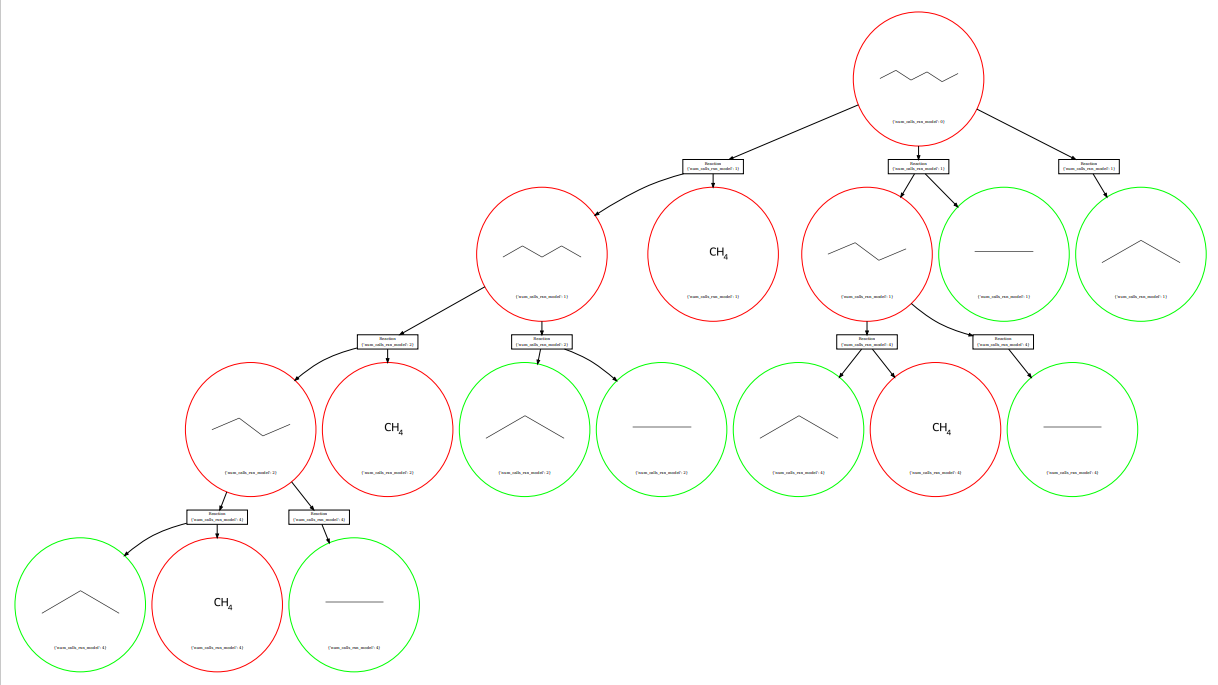

In [17]:
# We can extract individual synthesis routes from the above using "route extraction"
from syntheseus.search.analysis import route_extraction

# This iterator returns sets of nodes which constitute synthesis routes
for i, route_nodes in enumerate(route_extraction.iter_routes_cost_order(output_graph, max_routes=100)):
    visualization.visualize_andor(output_graph, filename=f"Route {i+1}.pdf", nodes=route_nodes)

The code above should return 2 routes, which look like the following:

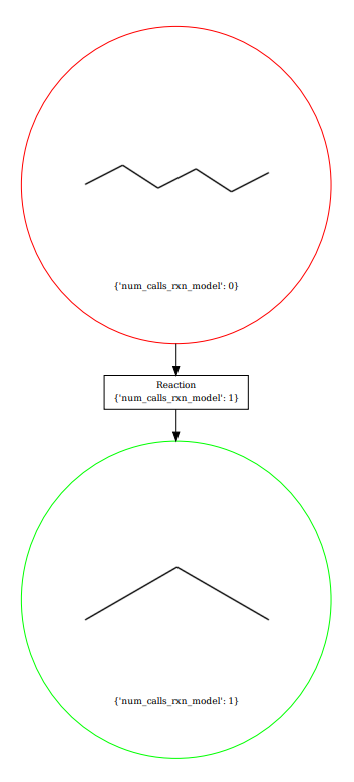

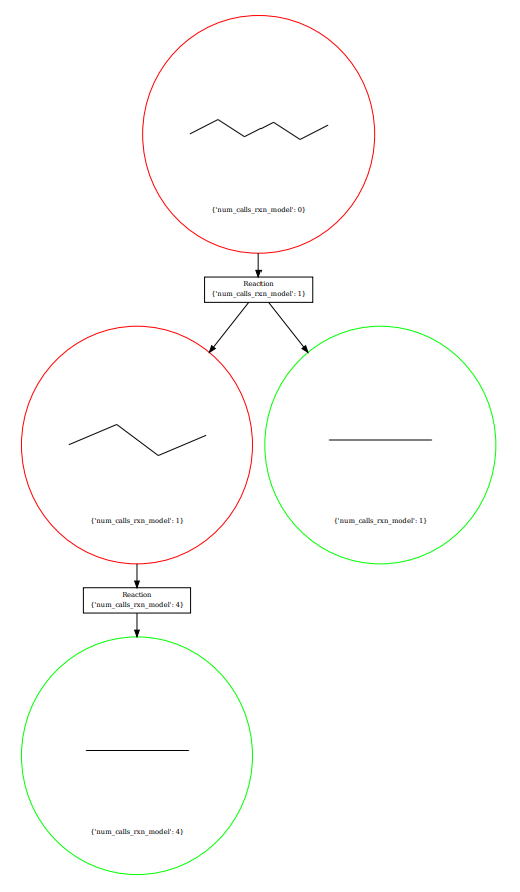